In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hmmlearn.hmm as hmm
from math import floor
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,roc_curve
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import os
import glob
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from itertools import product
from pathlib import Path
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense

C:\Users\masol\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def get_all_raw_data(file_prefix='pipeline/data_files/raw_mags_1m', file_extension="csv"):
    """"
    Takes in the daily financial data and outputs a dataframe of the concatenated dataset of OHCLV data for the entire available period.
    
    file_prefix: filepath and prefix for all raw OHCLV data files
    file_extension: File type for all raw OHCLV data files 
    """
    
    # Define the file prefix and extension 
    file_extension = 'csv'

    # Create the search pattern using a wildcard '*'
    # e.g., 'your_prefix_*.csv'
    pattern = f"{file_prefix}*.{file_extension}" 

    # Get a list of all files matching the pattern
    # You can specify a full directory path if needed, e.g., 'path/to/files/{pattern}'
    file_list = glob.glob(pattern)

    # Initialize an empty list to store individual DataFrames
    dfs = []

    # Loop through the files, read each into a DataFrame, and append to the list
    for filename in file_list:
        df = pd.read_csv(filename)
        dfs.append(df)

    # Concatenate all DataFrames in the list
    # ignore_index=True ensures a continuous index in the final DataFrame, discarding original indices
    combined_df = pd.concat(dfs, ignore_index=True)

    # Display the first few rows of the combined DataFrame
    #print(combined_df.head())
    return combined_df.drop_duplicates()

In [3]:
features=pd.read_csv("pipeline/data_files/features_combined.csv").drop_duplicates()
features['Datetime']=pd.to_datetime(features['Datetime'])

C:\Users\masol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\masol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\masol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='hist_vol'>

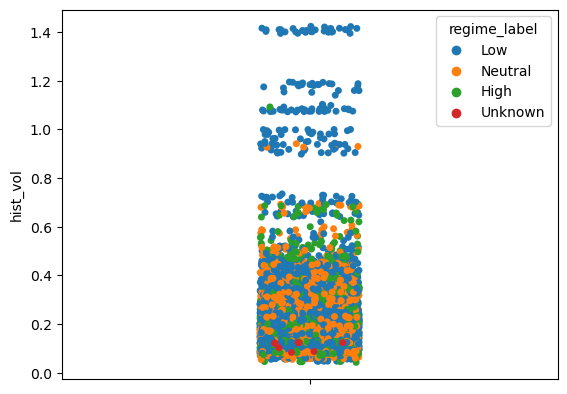

In [4]:
sns.stripplot(data=features,y='hist_vol',hue='regime_label')

In [5]:
ohclv=get_all_raw_data()
ohclv['Datetime']=pd.to_datetime(ohclv['Datetime'])
ohclv['Datetime']=ohclv.Datetime.apply(lambda x:x.replace(tzinfo=None))-pd.Timedelta(hours=5)

In [6]:
ohclv.Datetime

0       2025-10-29 08:30:00
1       2025-10-29 08:31:00
2       2025-10-29 08:32:00
3       2025-10-29 08:33:00
4       2025-10-29 08:34:00
                ...        
23614   2025-12-02 15:55:00
23615   2025-12-02 15:56:00
23616   2025-12-02 15:57:00
23617   2025-12-02 15:58:00
23618   2025-12-02 15:59:00
Name: Datetime, Length: 9196, dtype: datetime64[ns]

In [7]:
df=ohclv.merge(features,on='Datetime',how='inner')

In [8]:
features.drop_duplicates()

,Datetime,news_cnt_5m,news_cnt_15m,news_cnt_60m,sent_sum_pos_5m,sent_sum_neg_5m,sent_net_5m,sent_sum_pos_15m,sent_sum_neg_15m,sent_net_15m,...,trump_sum_neg_5m,trump_net_5m,trump_sum_pos_15m,trump_sum_neg_15m,trump_net_15m,trump_sum_pos_60m,trump_sum_neg_60m,trump_net_60m,trump_sent_ewma,regime_label
0,2025-11-04 09:30:00,2.0,2.0,5.0,0.199735,0.889115,-0.068938,0.199735,0.889115,-0.022979,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.537938,Low
1,2025-11-04 09:31:00,3.0,3.0,6.0,0.751101,0.899446,0.039269,0.751101,0.899446,0.013090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.537938,Low
2,2025-11-04 09:32:00,3.0,3.0,6.0,0.751101,0.899446,0.039269,0.751101,0.899446,0.013090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.537938,Low
3,2025-11-04 09:33:00,4.0,4.0,7.0,1.699128,0.917015,0.225361,1.699128,0.917015,0.075120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.537938,Low
4,2025-11-04 09:34:00,4.0,4.0,7.0,1.699128,0.917015,0.225361,1.699128,0.917015,0.075120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.537938,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7573,2025-12-02 15:55:00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.357405,Unknown
7574,2025-12-02 15:56:00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.357405,Unknown
7575,2025-12-02 15:57:00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.357405,Unknown
7576,2025-12-02 15:58:00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.357405,Unknown


In [9]:
def create_train_test_data(feature_set_name='pipeline/data_files/features_combined.csv'
                           ,ohclv_name='pipeline/data_files/raw_mags_1m'
                           ,alternative_data=False):
    """
    Creates training and test data from a given feature table and OHCLV data.
    
    feature_set_name: relative filepath and name of the alternative data feature table
    ohclv_name: prefix of all OHCLV data files
    alternative_data: Boolean value indicating whether to include the alternative data in final training and test sets
    
    """
    df=pd.read_csv(feature_set_name)
    df['Datetime']=pd.to_datetime(df['Datetime'])
    ohclv=get_all_raw_data(ohclv_name)
    ohclv['Datetime']=pd.to_datetime(ohclv['Datetime'])
    ohclv['Datetime']=ohclv.Datetime.apply(lambda x:x.replace(tzinfo=None))-pd.Timedelta(hours=5)
    features=ohclv.merge(df,on='Datetime',how='inner')
    ids=features['Datetime']
    if alternative_data:
        X=features.drop(['Datetime','regime_label','pred_vol','hist_vol','vol_ratio'],axis=1)[features.regime_label!='Unknown']
    else:
        X=features[['open','high','low','close','close','volume']][features.regime_label!='Unknown']
    y=features['regime_label'].replace({'Unknown':3,
                                       'Low':0,
                                       'Neutral':1,
                                       'High':2})[features.regime_label!='Unknown']
    train_x,test_x=X[:floor(len(features)*0.7)],X[floor(len(features)*0.7):]
    train_y,test_y=y[:floor(len(features)*0.7)],y[floor(len(features)*0.7):]
    
    return train_x,test_x,train_y,test_y
    

In [10]:
train_x,test_x,train_y,test_y=create_train_test_data(alternative_data=False)

C:\Users\masol\AppData\Local\Temp\ipykernel_44928\1492966488.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y=features['regime_label'].replace({'Unknown':3,


In [11]:
def model_initialization(train_x=train_x,train_y=train_y):
    """
    Initiliaze parameters for a Hidden Markov Model using a given training set and return a trained model
    
    train_x:dataset/numpy array of predictive features
    train_y: pandas series of numpy array of state labels
    """
    # Number of hidden states (regimes)
    n_components = len(np.unique(train_y))
    n_features = train_x.shape[1]

    # Manually compute the parameters
    startprob = np.zeros(n_components)
    transmat = np.zeros((n_components, n_components))
    means = np.zeros((n_components, n_features))
    covars = np.zeros((n_components, n_features, n_features))
    
    # Loop through each regime to calculate emission parameters (mean and covariance)
    for i in range(n_components):
        regime_data = train_x[train_y == i]
        means[i] = regime_data.mean(axis=0)
        covars[i] = np.cov(regime_data, rowvar=False) + 1e-6 * np.eye(n_features) # Add epsilon for stability
    
    # Calculate transition probabilities from the labeled sequence
    for i in range(len(train_y) - 1):
        transmat[train_y[i], train_y[i+1]] += 1
        
    # Normalize transition matrix
    transmat = transmat / transmat.sum(axis=1, keepdims=True)
    
    # Calculate initial state probabilities (assuming first data point is labeled correctly)
    startprob[train_y[0]] = 1.0

    # Ensure no zero probabilities
    transmat[transmat == 0] = 1e-9
    transmat = transmat / transmat.sum(axis=1, keepdims=True)
    
    # Create a Gaussian HMM model and initialize with computed parameters
    model = hmm.GaussianHMM(n_components=n_components, covariance_type="full", init_params="")
    model.startprob_ = startprob
    model.transmat_ = transmat
    model.means_ = means
    model.covars_ = covars

    print("HMM model initialized successfully with supervised parameters.")
    print("Start probabilities:", model.startprob_)
    print("Transition matrix:", model.transmat_)
    print("Means (Emission parameters):", model.means_)


    return model

In [12]:
def forecasting_intialization(X=train_x,y=train_y):
    """
    
    """
    X=X.values
    lengths = [len(X)] # For a single time series

    # Initialize a GaussianHMM with the correct number of regimes (hidden states)
    n_regimes = y.nunique()
    model = hmm.GaussianHMM(n_components=n_regimes, n_iter=100)
    regimes=y

    # Manually set the known state sequence to guide training
    # hmmlearn does not have a built-in supervised training method, so we use
    # an iterative approach to find the most likely parameters for the given state sequence.
    # This is an alternative to standard EM for when labels are known.

    # Function to re-estimate parameters based on labeled data
    def fit_supervised_hmm(model, X, regimes):
        for i in range(model.n_iter):
            # E-step with known states
            # The E-step is skipped in favor of a known state sequence

            # M-step: Re-estimate parameters (startprob, transmat, means, covars)
            # We manually re-calculate the necessary statistics based on the known labels

            # Re-estimate start probabilities
            model.startprob_ = np.bincount(regimes[:1], minlength=model.n_components) / len(regimes[:1])

            # Re-estimate transition matrix
            for i in range(model.n_components):
                for j in range(model.n_components):
                    # Count transitions from state i to j
                    transitions = np.sum( (regimes[:-1] == i) & (regimes[1:] == j) )
                    total_transitions = np.sum(regimes[:-1] == i)
                    model.transmat_[i, j] = transitions / total_transitions if total_transitions > 0 else 0

            # Re-estimate means and covariances
            for i in range(model.n_components):
                # Isolate data for the current regime
                regime_data = X[regimes == i]
                if len(regime_data) > 0:
                    model.means_[i, :] = np.mean(regime_data, axis=0)
                    model.covars_[i, :, :] = np.cov(regime_data, rowvar=False) + 1e-6 * np.eye(X.shape[1]) # Add small value for numerical stability

        return model

    # Fit the supervised HMM model
    # Note: For real applications, a custom implementation or a different library might be more robust
    # For demonstration, the manual approach is shown.
    supervised_model = fit_supervised_hmm(model, X, y.values)

    # Evaluate the model (optional, but recommended)
    print("Fitted Model Parameters:")
    print("Start probabilities:\n", supervised_model.startprob_)
    print("Transition matrix:\n", supervised_model.transmat_)
    print("Regime Means:\n", supervised_model.means_)
    print("Regime Covariances:\n", supervised_model.covars_)


    return model

In [13]:
#"hmm_forecaster=forecasting_intialization(X=train_x,y=train_y)

In [14]:
hmm_model =model_initialization()

HMM model initialized successfully with supervised parameters.
Start probabilities: [1. 0. 0.]
Transition matrix: [[0.91505935 0.06194362 0.02299703]
 [0.0893887  0.87485582 0.03575548]
 [0.07960742 0.05452563 0.86586696]]
Means (Emission parameters): [[   65.71875727    65.74206298    65.69371839    65.7176022
     65.7176022  10776.68212166]
 [   65.49284983    65.51647129    65.46798151    65.49210171
     65.49210171  9338.21164937]
 [   65.41781757    65.44596811    65.38585704    65.41447871
     65.41447871 15493.96296296]]


In [15]:
# Use the trained HMM to predict the hidden state sequence
# `model.decode()` returns the log-likelihood and the optimal state sequence
log_prob, predicted_regimes = hmm_model.decode(test_x, algorithm="viterbi")
probs=hmm_model.predict_proba(test_x)

print("\nPredicted regime sequence for new data:")
print(predicted_regimes)


Predicted regime sequence for new data:
[0 1 1 ... 1 1 1]


In [16]:
accuracy_score(test_y,predicted_regimes)
roc_auc_score(test_y,probs,multi_class='ovr')

0.5330610333098929

# Random Forest

In [17]:
def create_lag_train_test_data(feature_set_name='pipeline/data_files/features_combined.csv'
                           ,ohclv_name='pipeline/data_files/raw_mags_1m.csv'
                           ,alternative_data=False):
    df=pd.read_csv(feature_set_name)
    df['Datetime']=pd.to_datetime(df['Datetime'])
    ohclv=get_all_raw_data()
    ohclv['Datetime']=pd.to_datetime(ohclv['Datetime'])
    ohclv['Datetime']=ohclv.Datetime.apply(lambda x:x.replace(tzinfo=None))-pd.Timedelta(hours=5)
    features=ohclv.merge(df,on='Datetime',how='inner')
    ids=features['Datetime']
    if alternative_data:
        X=features.drop(['Datetime','regime_label','pred_vol','hist_vol','vol_ratio'],axis=1)[features.regime_label!='Unknown']
    else:
        X=features[['open','high','low','close','close','volume']][features.regime_label!='Unknown']
    X=X.shift(10)
    
    scaler=StandardScaler()
    y=features['regime_label'].replace({'Unknown':3,
                                       'Low':0,
                                       'Neutral':1,
                                       'High':2})[features.regime_label!='Unknown']
    X['target_lag']=y.shift(1)
    train_x,test_x=X[:floor(len(features)*0.7)],X[floor(len(features)*0.7):]
    train_y,test_y=y[:floor(len(features)*0.7)],y[floor(len(features)*0.7):]
    #train_x_scaled=pd.DataFrame(scaler.fit_transform(train_x),columns=X.columns)
    #test_x_scaled=pd.DataFrame(scaler.transform(test_x),columns=X.columns)
    
    return train_x[10:],test_x[10:],train_y[10:],test_y[10:]

In [18]:
train_x_lag,test_x_lag,train_y_lag,test_y_lag=create_lag_train_test_data(alternative_data=True)
train_x_lag_alt,test_x_lag_alt,train_y_lag_alt,test_y_lag_alt=create_lag_train_test_data(alternative_data=True)

C:\Users\masol\AppData\Local\Temp\ipykernel_44928\2763523607.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y=features['regime_label'].replace({'Unknown':3,
C:\Users\masol\AppData\Local\Temp\ipykernel_44928\2763523607.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y=features['regime_label'].replace({'Unknown':3,


In [19]:
train_x_lag

,open,high,low,close,volume,news_cnt_5m,news_cnt_15m,news_cnt_60m,sent_sum_pos_5m,sent_sum_neg_5m,...,trump_sum_neg_5m,trump_net_5m,trump_sum_pos_15m,trump_sum_neg_15m,trump_net_15m,trump_sum_pos_60m,trump_sum_neg_60m,trump_net_60m,trump_sent_ewma,target_lag
10,67.370003,67.500000,67.370003,67.500000,245051.0,2.0,2.0,5.0,0.199735,0.889115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.537938,0.0
11,67.500000,67.559998,67.459999,67.544998,31005.0,3.0,3.0,6.0,0.751101,0.899446,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.537938,0.0
12,67.544998,67.570000,67.500099,67.525002,34675.0,3.0,3.0,6.0,0.751101,0.899446,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.537938,0.0
13,67.510002,67.510002,67.330002,67.339996,33751.0,4.0,4.0,7.0,1.699128,0.917015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.537938,0.0
14,67.339996,67.389999,67.305000,67.375000,29192.0,4.0,4.0,7.0,1.699128,0.917015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.537938,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5343,63.435001,63.465000,63.410198,63.410198,3630.0,6.0,10.0,35.0,2.448710,1.726245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.044847,2.0
5344,63.465000,63.516499,63.465000,63.516499,5599.0,4.0,10.0,35.0,1.999204,1.568980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.044847,2.0
5345,63.529999,63.552101,63.525002,63.552101,3540.0,1.0,11.0,36.0,0.012450,0.965055,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.044847,2.0
5346,63.549999,63.565102,63.520000,63.560001,6518.0,2.0,12.0,37.0,0.527786,0.987292,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.044847,2.0


In [20]:
def blocked_cv(X,y,classifier,param_grid):

    # Initialize TimeSeriesSplit
    # n_splits determines the number of splits (folds)
    # gap allows for a gap between the training and testing sets
    # max_train_size can limit the maximum size of the training set
    results=[]
    best_score = -np.inf
    result_grid={}
    tscv = TimeSeriesSplit(n_splits=5)
    param_combinations=list(product(*param_grid.values()))
    param_keys = list(param_grid.keys())
    for comb in param_combinations:
        current_params = dict(zip(param_keys, comb))
        model=RandomForestClassifier(random_state=24,**current_params)
        
        fold_score=[]
        # Iterate through the splits
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            model.fit(X_train,y_train)
            probs=model.predict_proba(X_test)
            fold_score.append(roc_auc_score(y_test,probs,multi_class='ovr'))
        avg_score=np.mean(fold_score)
        std_score=np.std(fold_score)
        results.append({'params': current_params, 'avg_score': avg_score,'std_score':std_score})
        
        if avg_score > best_score:
            best_score = avg_score
            best_params = current_params
    #for res in results:
    #    key={res['params']}
    #    score={res['avg_score']}
    #    result_grid[key]=score
        
    return results

In [23]:
param_grid={
'n_estimators':[172],#89 alt 164
'max_depth':[9],#9 alt 25
'max_features':[10]#12 alt 10
}
blocked_cv(train_x_lag_alt,train_y_lag_alt,classifier=RandomForestClassifier(random_state=24),param_grid=param_grid)

[{'params': {'n_estimators': 172, 'max_depth': 9, 'max_features': 1},
  'avg_score': 0.8094087061782936,
  'std_score': 0.054452116593408754},
 {'params': {'n_estimators': 172, 'max_depth': 9, 'max_features': 2},
  'avg_score': 0.8565474581085535,
  'std_score': 0.037723542766343064},
 {'params': {'n_estimators': 172, 'max_depth': 9, 'max_features': 3},
  'avg_score': 0.8816765316441145,
  'std_score': 0.031909115510021874},
 {'params': {'n_estimators': 172, 'max_depth': 9, 'max_features': 4},
  'avg_score': 0.890265624181137,
  'std_score': 0.029122634944646383},
 {'params': {'n_estimators': 172, 'max_depth': 9, 'max_features': 5},
  'avg_score': 0.9055714749781177,
  'std_score': 0.010235513233711429},
 {'params': {'n_estimators': 172, 'max_depth': 9, 'max_features': 6},
  'avg_score': 0.8973652039685154,
  'std_score': 0.02904853743524947},
 {'params': {'n_estimators': 172, 'max_depth': 9, 'max_features': 7},
  'avg_score': 0.9072561227303769,
  'std_score': 0.008450973550250986},
 

In [24]:
def compare_scores(train_x,train_y,test_x,test_y,
                  train_x_alt,test_x_alt):

    rf_alt=RandomForestClassifier(random_state=42,n_estimators=172,max_depth=9,max_features=10)
    rf=RandomForestClassifier(random_state=42,n_estimators=89,max_depth=9,max_features=12)
        
    rf.fit(train_x,train_y)
    rf_alt.fit(train_x_alt,train_y)
    probs_train=rf.predict_proba(train_x)
    probs=rf.predict_proba(test_x)
    probs_alt_train=rf_alt.predict_proba(train_x)
    probs_alt=rf_alt.predict_proba(test_x_alt)
    score=roc_auc_score(test_y,probs,multi_class='ovr')
    score_alt=roc_auc_score(test_y,probs_alt,multi_class='ovr')
    
    probs_frame_1=pd.DataFrame(probs_train,columns=['probability_low','probability_medium','probability_high'])
    probs_frame_2=pd.DataFrame(probs,columns=['probability_low','probability_medium','probability_high'])
    probs_frame_1['set']='train'
    probs_frame_2['set']='test'
    
    alt_frame_1=pd.DataFrame(probs_alt_train,columns=['probability_low_with_alt','probability_medium_with_alt','probability_high_with_alt'])
    alt_frame_2=pd.DataFrame(probs_alt,columns=['probability_low_with_alt','probability_medium_with_alt','probability_high_with_alt']) 
    alt_frame_1['set']='train'
    alt_frame_2['set']='test'   
    
    return score_alt,score,pd.concat([alt_frame_1,alt_frame_2]),pd.concat([probs_frame_1,probs_frame_2])
    

In [37]:
score_alt,score_norm,probs_alt,probs=\
compare_scores(train_x_lag,train_y_lag,test_x_lag,test_y_lag,train_x_lag_alt,test_x_lag_alt)

In [38]:
score_alt,score_norm

(0.9147937546870497, 0.9140305548407538)

In [33]:
def create_results_frame(features,probs_alt,probs,output_path='model/data_files/results.csv'):
    labels=pd.concat([features[10:floor(len(features)*0.7)],features[floor(len(features)*0.7):][10:]])[['Datetime','regime_label']]
    labels=labels[labels.regime_label!='Unknown']
    
    results=pd.concat([labels.reset_index(drop=True),probs.reset_index(drop=True),probs_alt.reset_index(drop=True)],axis=1)
    
    results.dropna(subset='Datetime').to_csv(output_path)
    
    return results

In [34]:
create_results_frame(features,probs_alt,probs)

,Datetime,regime_label,probability_low,probability_medium,probability_high,set,probability_low_with_alt,probability_medium_with_alt,probability_high_with_alt,set
0,2025-11-04 09:40:00,Low,0.916202,0.038192,0.045607,train,0.884933,0.059009,0.056058,train
1,2025-11-04 09:41:00,Low,0.933936,0.047174,0.018890,train,0.925894,0.048959,0.025147,train
2,2025-11-04 09:42:00,Low,0.926985,0.054186,0.018829,train,0.921060,0.048259,0.030681,train
3,2025-11-04 09:43:00,Low,0.931633,0.050650,0.017717,train,0.930543,0.047137,0.022319,train
4,2025-11-04 09:44:00,Low,0.931637,0.049805,0.018558,train,0.922094,0.049296,0.028609,train
...,...,...,...,...,...,...,...,...,...,...
7608,NaT,NaN,0.066992,0.843824,0.089183,test,0.096350,0.807833,0.095816,test
7609,NaT,NaN,0.066992,0.843824,0.089183,test,0.095281,0.807648,0.097071,test
7610,NaT,NaN,0.063484,0.078446,0.858070,test,0.068850,0.114640,0.816510,test
7611,NaT,NaN,0.061864,0.091041,0.847095,test,0.074226,0.124451,0.801323,test


In [30]:
features

,Datetime,news_cnt_5m,news_cnt_15m,news_cnt_60m,sent_sum_pos_5m,sent_sum_neg_5m,sent_net_5m,sent_sum_pos_15m,sent_sum_neg_15m,sent_net_15m,...,trump_sum_neg_5m,trump_net_5m,trump_sum_pos_15m,trump_sum_neg_15m,trump_net_15m,trump_sum_pos_60m,trump_sum_neg_60m,trump_net_60m,trump_sent_ewma,regime_label
0,2025-11-04 09:30:00,2.0,2.0,5.0,0.199735,0.889115,-0.068938,0.199735,0.889115,-0.022979,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.537938,Low
1,2025-11-04 09:31:00,3.0,3.0,6.0,0.751101,0.899446,0.039269,0.751101,0.899446,0.013090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.537938,Low
2,2025-11-04 09:32:00,3.0,3.0,6.0,0.751101,0.899446,0.039269,0.751101,0.899446,0.013090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.537938,Low
3,2025-11-04 09:33:00,4.0,4.0,7.0,1.699128,0.917015,0.225361,1.699128,0.917015,0.075120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.537938,Low
4,2025-11-04 09:34:00,4.0,4.0,7.0,1.699128,0.917015,0.225361,1.699128,0.917015,0.075120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.537938,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7573,2025-12-02 15:55:00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.357405,Unknown
7574,2025-12-02 15:56:00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.357405,Unknown
7575,2025-12-02 15:57:00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.357405,Unknown
7576,2025-12-02 15:58:00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.357405,Unknown


# LSTM

In [ ]:
def Sequence_data_creator(sequence_length=10,feature_set_name='pipeline/data_files/features_combined.csv'
                           ,ohclv_name='pipeline/data_files/raw_mags_1m.csv'
                           ,alternative_data=False):
    df=pd.read_csv(feature_set_name)
    df['Datetime']=pd.to_datetime(df['Datetime'])
    ohclv=get_all_raw_data(ohclv_name)
    ohclv['Datetime']=pd.to_datetime(ohclv['Datetime'])
    ohclv['Datetime']=ohclv.Datetime.apply(lambda x:x.replace(tzinfo=None))-pd.Timedelta(hours=5)
    features=ohclv.merge(df,on='Datetime',how='inner')
    ids=features['Datetime']
    if alternative_data:
        X=features.drop(['Datetime','regime_label','pred_vol','hist_vol','vol_ratio'],axis=1)[features.regime_label!='Unknown']
    else:
        X=features[['open','high','low','close','close','volume']][features.regime_label!='Unknown']
    y=features['regime_label'].replace({'Unknown':3,
                                       'Low':0,
                                       'Neutral':1,
                                       'High':2})[features.regime_label!='Unknown']
    scaler=StandardScaler()
    X=scaler.fit_transoform(X)
    num_features = structured_data.shape[1]
    
    # Create sequences
    # Using a simple sliding window to create sequences
    sequences = []
    labels = [] # Assuming you have a label for each sequence
    for i in range(len(X) - sequence_length):
        sequences.append(X[i : i + sequence_length])
        # Assuming the label corresponds to the last element in the sequence
        labels.append(y[i + sequence_length - 1])
        
    sequences = np.array(sequences)
    labels = np.array(labels)

    # Convert to PyTorch tensors
    X = torch.tensor(sequences, dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.long) # Use long for classification labels
    
     from torch.utils.data import Dataset, DataLoader

    class StructuredDataset(Dataset):
        def __init__(self, X, y):
            self.X = X
            self.y = y

        def __len__(self):
            return len(self.X)

        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

    dataset = StructuredDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    return dataloader
    
    

In [ ]:
import torch.nn as nn

    class LSTMClassifier(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, num_classes):
            super(LSTMClassifier, self).__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_size, num_classes)

        def forward(self, x):
            # Initialize hidden and cell states
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

            # Forward propagate LSTM
            out, _ = self.lstm(x, (h0, c0))

            # Take the output from the last time step for classification
            out = self.fc(out[:, -1, :])
            return out
